In [6]:
import pandas as pd
import numpy as np
GOOGLE_APPLICATION_CREDENTIALS  = "ascendkey.json"
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os

In [7]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='ascendkey.json'


In [9]:
query = """
WITH MEMBERSHIP_INVOICES AS
(
SELECT
  ii.invoice_id as INVOICE_ID
FROM
  `arboreal-groove-323317.data_analytics.invoice-items-SS` ii
WHERE
  product_id =1021)
,
INVOICES AS 
(
 SELECT INVOICES.INVOICE_ID, CUSTOMER_ID, CHARGETO_CUSTOMER_ID, POSTDATE, AMOUNT, INVTYPE,
 ROW_NUMBER() OVER (PARTITION BY  CUSTOMER_ID ORDER BY POSTDATE) as INV_ORDER
    FROM `arboreal-groove-323317.data_analytics.invoices-SS` INVOICES
 INNER JOIN MEMBERSHIP_INVOICES  on INVOICES.INVOICE_ID = MEMBERSHIP_INVOICES.INVOICE_ID 
 where postdate < '2020-03-01'
)
,
END_INV AS
(select 
invoices.invoice_id, invoices.customer_id, invoices.CHARGETO_CUSTOMER_ID, invoices.postdate as start_date, 
invoices_end.postdate as end_date
 from invoices
 inner join invoices invoices_end
 on invoices.customer_id = invoices_end.customer_id and
 (invoices.inv_order + 1) = invoices_end.inv_order
)



SELECT distinct checkins.CHECKIN_ID, checkins.CUSTOMER_ID as CUST_ID, cast(checkins.POSTDATE as datetime) as visittime,
checkins.STATUS,  
customers.CURRENT_STATUS, END_INV.*,
ROW_NUMBER() OVER (PARTITION BY  checkins.CUSTOMER_ID, end_inv.invoice_id ORDER BY POSTDATE) as Checkin_count
FROM `arboreal-groove-323317.data_analytics.checkins-SS_copy` checkins
INNER JOIN `arboreal-groove-323317.data_analytics.customers_SS` customers
on checkins.CUSTOMER_ID = cast(customers.customer_id as INT)
inner join END_INV 
on checkins.CUSTOMER_ID = END_INV.CUSTOMER_ID
and cast(checkins.POSTDATE as datetime) > cast(END_INV.start_date  as datetime)
and cast(checkins.POSTDATE as datetime) < cast(END_INV.end_date  as datetime)
where cast(checkins.POSTDATE as datetime) <  cast('2020-03-01' as datetime)


order by 2,3
"""

bq_client = bigquery.Client()
query_job = bq_client.query((query),) # BigQuery API request
invoices = query_job.result().to_dataframe()

In [10]:
invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234335 entries, 0 to 234334
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   CHECKIN_ID            234335 non-null  int64              
 1   CUST_ID               234335 non-null  int64              
 2   visittime             234335 non-null  datetime64[ns]     
 3   STATUS                234335 non-null  object             
 4   CURRENT_STATUS        234335 non-null  object             
 5   invoice_id            234335 non-null  int64              
 6   customer_id           234335 non-null  int64              
 7   CHARGETO_CUSTOMER_ID  234335 non-null  int64              
 8   start_date            234335 non-null  datetime64[ns, UTC]
 9   end_date              234335 non-null  datetime64[ns, UTC]
 10  Checkin_count         234335 non-null  int64              
dtypes: datetime64[ns, UTC](2), datetime64[ns](1), int64(

In [11]:
missing = pd.concat([invoices.isnull().sum(), 100 * invoices.isnull().mean()], axis=1)
missing.columns=['count', '%']



In [12]:
missing

,count,%
CHECKIN_ID,0,0.0
CUST_ID,0,0.0
visittime,0,0.0
STATUS,0,0.0
CURRENT_STATUS,0,0.0
invoice_id,0,0.0
customer_id,0,0.0
CHARGETO_CUSTOMER_ID,0,0.0
start_date,0,0.0
end_date,0,0.0


In [14]:
invoices['checkin_one'] = 1

In [15]:
invoices['CUST_ID'].nunique()

4211

In [1]:
invoices['CUST_ID', 'invoice_id'].nunique()

NameError: name 'invoices' is not defined

In [16]:
visits_per_customer = invoices.groupby(
    ['CUST_ID'], as_index=False).agg(
    {'checkin_one':sum}
)

In [ ]:
invoices_per_customer_per_inv = 

In [17]:
visits_per_customer.drop("CUST_ID", axis=1, inplace=True)

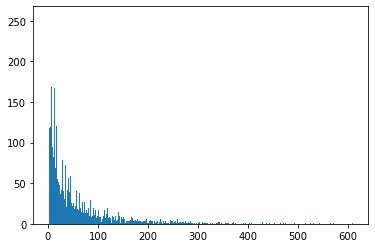

In [22]:
plt.hist(visits_per_customer, bins = 500)

plt.show()

In [ ]:
ends_by_month =

In [ ]:
missing values?
nas
get histograms going for number of checkins per checkin id, per start/end period
how many invoices per customer?

status column - use last checkin or something like this to determine status

survival analysis
LTV - lifetimes package
machine learning -predicting churn

In [ ]:
CHECKIN_ID the unique id assigned to the checkin to the facility
CUST_ID the unique id assigned to the customer
visittime the timestamp of the checkin
STATUS the status of the customer at the time of the checkin
CURRENT_STATUS the status of the customer today
invoice_id the bill that enabled the customer to have a checkin
customer_id repeated customer ID
CHARGETO_CUSTOMER_ID the customer id of the person responsible for the bill. i.e., a parent if a child is checking in
start_date the start date of the invoice paying for the checkin
end_date the end date of the invoice paying for the checkin
Checkin_count the count of checkins within an invoice period per customer id